# First Pass Using Fastai Tabular For Homesite Competition
> Here I use fastai with as many defaults as possible to make a "first-pass" submission to Kaggle for the Homesite competition.

- toc: true 
- badges: true
- comments: true
- categories: [kaggle, fastai]
- author: Nissan Dookeran
- image: images/chart-preview.png

## Introduction

Here I will submit an entry to the Homesite Competition on Kaggle Competition using Google Colab to get a first pass submission going, but mainly ignore what was discovered in the [initial exploratory data analysis](https://redditech.github.io/team-fast-tabulous/kaggle/2021/06/23/Exploring-Homesite_Data.html) at this time, since we want a baseline for comparison after applying what we learn there to see how it improves (or not) our submission then.

## Setup fastai and Google drive

In [1]:
!pip install -Uqq fastai


In [2]:
from fastai.tabular.all import *

The snippet below is only useful in Colab for accessing my Google Drive and is straight out the [fastbook source code in Github](https://github.com/fastai/course20/blob/master/fastbook/__init__.py) 

In [3]:
global gdrive
gdrive = Path('/content/gdrive/My Drive')
from google.colab import drive
if not gdrive.exists(): drive.mount(str(gdrive.parent))

> Only add the Kaggle bits below if I'm running locally, in Collab they're already here

In [4]:
#!pip install kaggle

In [5]:
!ls /content/gdrive/MyDrive/Kaggle/kaggle.json

/content/gdrive/MyDrive/Kaggle/kaggle.json


Useful links here:
- Documentation on [Path library](https://docs.python.org/3/library/pathlib.html#basic-use)
- Documentation on [fastai extensions to Path library](https://fastcore.fast.ai/xtras.html#Extensions-to-Pathlib.Path)

In [6]:
Path.cwd()

Path('/content')

## Setup kaggle environment parameters

In [7]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
from kaggle import api

In [9]:
path = Path.cwd()
path.ls()

(#4) [Path('/content/.config'),Path('/content/models'),Path('/content/gdrive'),Path('/content/sample_data')]

In [10]:
path = path/"gdrive/MyDrive/Kaggle/homesite_data"
path.mkdir(exist_ok=True)
Path.BASE_PATH = path
api.competition_download_cli('homesite-quote-conversion', path=path)
file_extract(path/"homesite-quote-conversion.zip")
file_extract(path/"train.csv.zip")
file_extract(path/"test.csv.zip")

homesite-quote-conversion.zip: Skipping, found more recently modified local copy (use --force to force download)


In [11]:
path

Path('.')

In [12]:
path.ls()

(#9) [Path('homesite-quote-conversion.zip'),Path('models'),Path('sample_submission.csv.zip'),Path('test.csv.zip'),Path('train.csv.zip'),Path('train.csv'),Path('test.csv'),Path('sample_submission.csv'),Path('submission.csv')]

## Exploring the Homesite data

First set the random seed so that the results are reproducible

In [13]:
set_seed(42) 

In [14]:
df_train = pd.read_csv(path/"train.csv", low_memory=False)
df_train.head()

,QuoteNumber,Original_Quote_Date,QuoteConversion_Flag,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,...,GeographicField44A,GeographicField44B,GeographicField45A,GeographicField45B,GeographicField46A,GeographicField46B,GeographicField47A,GeographicField47B,GeographicField48A,GeographicField48B,GeographicField49A,GeographicField49B,GeographicField50A,GeographicField50B,GeographicField51A,GeographicField51B,GeographicField52A,GeographicField52B,GeographicField53A,GeographicField53B,GeographicField54A,GeographicField54B,GeographicField55A,GeographicField55B,GeographicField56A,GeographicField56B,GeographicField57A,GeographicField57B,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,1,2013-08-16,0,B,23,0.9403,0.0006,965,1.0200,N,17,23,17,23,15,22,16,22,13,22,13,23,T,D,2,1,7,18,3,8,0,5,5,24,V,48649,0,0,0,0,...,8,4,20,22,10,8,6,5,15,13,19,18,16,14,21,23,21,23,16,11,22,24,7,14,-1,17,15,17,14,18,9,9,-1,8,-1,18,-1,10,N,CA
1,2,2014-04-22,0,F,7,1.0006,0.0040,548,1.2433,N,6,8,6,8,5,7,5,8,13,22,13,23,T,E,5,9,5,14,6,18,1,5,5,11,P,26778,0,0,1,1,...,23,24,11,15,21,24,6,11,21,21,18,15,20,20,13,12,12,12,15,9,13,11,11,20,-1,9,18,21,8,7,10,10,-1,11,-1,17,-1,20,N,NJ
2,4,2014-08-25,0,F,7,1.0006,0.0040,548,1.2433,N,7,12,7,12,6,10,7,11,25,25,13,23,T,J,4,6,3,10,4,11,1,5,5,11,K,8751,0,0,2,2,...,21,22,24,25,20,22,7,13,23,23,20,19,20,20,18,20,19,21,20,19,11,8,3,3,-1,5,21,24,12,15,15,18,-1,21,-1,11,-1,8,N,NJ
3,6,2013-04-15,0,J,10,0.9769,0.0004,"1,165",1.2665,N,3,2,3,2,2,2,3,2,13,22,13,23,Y,F,15,23,8,19,14,24,0,5,5,23,V,43854,0,0,0,0,...,3,1,14,22,6,2,7,14,11,8,19,18,18,16,13,12,13,12,17,13,5,2,3,4,-1,7,14,14,14,18,6,5,-1,10,-1,9,-1,21,N,TX
4,8,2014-01-25,0,E,23,0.9472,0.0006,"1,487",1.3045,N,8,13,8,13,7,11,7,13,13,22,13,23,T,F,4,6,3,6,3,6,1,5,5,7,R,12505,1,0,0,0,...,24,25,9,11,25,25,5,3,22,22,21,21,17,15,25,25,25,25,17,13,13,11,3,4,-1,7,11,9,10,10,18,22,-1,10,-1,11,-1,12,N,IL


In [15]:
df_train.shape

(260753, 299)

In [16]:
df_test = pd.read_csv(path/"test.csv", low_memory=False)
df_test.head()

,QuoteNumber,Original_Quote_Date,Field6,Field7,Field8,Field9,Field10,Field11,Field12,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField3,SalesField4,SalesField5,SalesField6,SalesField7,SalesField8,SalesField9,SalesField10,SalesField11,SalesField12,SalesField13,...,GeographicField44A,GeographicField44B,GeographicField45A,GeographicField45B,GeographicField46A,GeographicField46B,GeographicField47A,GeographicField47B,GeographicField48A,GeographicField48B,GeographicField49A,GeographicField49B,GeographicField50A,GeographicField50B,GeographicField51A,GeographicField51B,GeographicField52A,GeographicField52B,GeographicField53A,GeographicField53B,GeographicField54A,GeographicField54B,GeographicField55A,GeographicField55B,GeographicField56A,GeographicField56B,GeographicField57A,GeographicField57B,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64
0,3,2014-08-12,E,16,0.9364,0.0006,"1,487",1.3045,N,4,4,4,4,3,3,3,4,13,22,13,23,Y,K,13,22,6,16,9,21,0,5,5,11,P,67052,0,0,0,0,0,...,22,23,9,12,25,25,6,9,4,2,16,12,20,20,2,2,2,1,1,1,10,7,25,25,-1,19,19,22,12,15,1,1,-1,1,-1,20,-1,25,Y,IL
1,5,2013-09-07,F,11,0.9919,0.0038,564,1.1886,N,8,14,8,14,7,12,8,13,13,22,13,23,T,E,4,5,3,6,3,6,1,5,5,4,R,27288,1,0,0,0,0,...,23,24,12,21,23,25,7,11,16,14,13,6,17,15,7,5,7,5,13,7,14,14,7,14,-1,4,1,1,5,3,10,10,-1,5,-1,5,-1,21,N,NJ
2,7,2013-03-29,F,15,0.8945,0.0038,564,1.0670,N,11,18,11,18,10,16,10,18,13,22,13,23,T,E,3,3,5,14,3,9,1,5,5,23,V,65264,0,1,2,2,0,...,16,18,9,10,14,16,6,8,20,19,17,14,16,13,20,22,20,22,20,18,10,7,4,7,-1,11,13,12,18,22,10,11,-1,20,-1,22,-1,11,N,NJ
3,9,2015-03-21,K,21,0.8870,0.0004,"1,113",1.2665,Y,14,22,15,22,13,20,22,25,13,22,13,23,Y,F,5,9,9,20,5,16,1,5,5,11,R,32725,1,1,1,1,0,...,11,11,9,10,11,13,15,21,14,12,17,13,10,6,20,22,20,22,19,16,12,11,4,6,-1,13,10,8,5,3,8,8,-1,13,-1,8,-1,21,N,TX
4,10,2014-12-10,B,25,0.9153,0.0007,935,1.0200,N,4,5,4,5,4,4,4,5,13,22,13,23,Y,D,12,21,1,1,3,6,0,5,5,11,T,56025,0,1,1,1,0,...,9,8,25,25,9,3,9,18,7,4,16,12,13,9,8,6,8,6,11,5,19,21,13,21,-1,23,11,8,5,3,7,7,-1,3,-1,22,-1,21,N,CA


In [17]:
df_test.shape

(173836, 298)

In [18]:
y_column = df_train.columns.difference(df_test.columns)

In [19]:
y_column

Index(['QuoteConversion_Flag'], dtype='object')

From this it looks like `QuoteConversion_Flag` is the value we want to predict. Let's take a look at this

In [20]:
type(df_train.QuoteConversion_Flag)

pandas.core.series.Series

In [21]:
df_train.QuoteConversion_Flag.unique()

array([0, 1])

In [22]:
type(df_train.QuoteConversion_Flag.unique()[0])

numpy.int64

Make this a boolean for the purpose of generating predictions as a binary classification

In [23]:
df_train.QuoteConversion_Flag = df_train.QuoteConversion_Flag.astype(dtype='boolean')

Let's see how the training data outcomes are balanced

In [24]:
df_train.QuoteConversion_Flag.describe()

count     260753
unique         2
top        False
freq      211859
Name: QuoteConversion_Flag, dtype: object

In [25]:
train_data_balance = pd.DataFrame(df_train["QuoteConversion_Flag"]).groupby("QuoteConversion_Flag")

In [26]:
train_data_balance["QuoteConversion_Flag"].describe()

,count,unique,top,freq
QuoteConversion_Flag,,,,
False,211859,1,False,211859
True,48894,1,True,48894


We have about 5 times as many "No Sale" data rows as we do data that shows a successful sale happened. This *data bias* may have an impact on the effectiveness of our model to predict positive sales results

## First things first 
Learning from [my colleague Tim's work](https://redditech.github.io/team-fast-tabulous/jupyter/2021/06/20/Identify-problem-type.html) already we know:
- `Quotenumber` is unique so we can make it the index
- `Original_Quote_Date` column should be set as a date type

Additionally, we should make sure to apply any changes to data types to both train and test data so predictions don't fail later on


In [27]:
df_train = df_train.set_index('QuoteNumber')
df_test = df_test.set_index('QuoteNumber')

We may have some NaN values for Original_Quote_Date in either the training or test dataset, but let's confirm there are none.

In [28]:
df_train['Original_Quote_Date'].isna().sum(), df_test['Original_Quote_Date'].isna().sum()

(0, 0)

In [29]:
df_train['Original_Quote_Date'] = pd.to_datetime(df_train['Original_Quote_Date'])
df_test['Original_Quote_Date'] = pd.to_datetime(df_test['Original_Quote_Date'])

## Goal: Quick and dirty model training, assuming fastai defaults for everything

In [30]:
y_names = [y_column[0]]
y_names

['QuoteConversion_Flag']

In [31]:
cont_names, cat_names = cont_cat_split(df_train, dep_var=y_names)
len(cont_names), len(cat_names)

(151, 146)

In [32]:
"QuoteConversion_Flag" in cont_names, "QuoteConversion_Flag" in cat_names #Make sure we've gotten our y-column excluded

(False, False)

In [33]:
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter()(range_of(df_train))

In [34]:
to = TabularPandas(df=df_train, procs=procs, cat_names=cat_names, cont_names=cont_names, y_names=y_names, splits=splits)
dls = to.dataloaders()
dls.valid.show_batch()

,Original_Quote_Date,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,PersonalField84_na,PropertyField29_na,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField29,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,Geographic

In [35]:
roc_auc_binary = RocAucBinary()
learn = tabular_learner(dls, metrics=roc_auc_binary)

In [36]:
type(roc_auc_binary)

fastai.metrics.AccumMetric

SuggestedLRs(valley=tensor(0.0025))

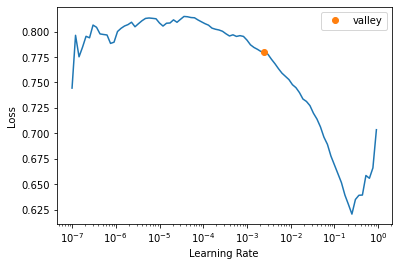

In [37]:
learn.lr_find()

[Reference to why we use fit_one_cycle](https://fastai1.fast.ai/callbacks.one_cycle.html)

> Note I ran `fit_one_cycle` with a value of 10 when prepping this notebook for publishing, but the test results came out suspiciously high on `1` outputs, given that the test submission I ran before was heavily weighted with `0` outputs and got a 0.83 score when I ran with `5` but I didn't set the random seed value then, so hopefully by setting the random seed this learning rate recommendation won't change when I run this notebook again later.

In [38]:
learn.fit_one_cycle(5, 0.0025)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.191083,0.190373,0.956380,01:57
1,0.182042,1.114478,0.961028,01:58
2,0.170142,0.192774,0.961783,01:58
3,0.160787,0.401845,0.963326,01:58
4,0.153714,0.460429,0.962740,01:58


Referenced another [Kaggle notebook](https://www.kaggle.com/quanghm/fastai-1-0-tabular-learner-with-ensemble?scriptVersionId=12269139) for this, we don't need it but it's good to see what fastai metrics is actually packaging up for you

In [39]:
preds, targs = learn.get_preds()


In [40]:
from sklearn.metrics import roc_auc_score
valid_score = roc_auc_score(to_np(targs), to_np(preds[:,1]))
valid_score

0.9627402127903286

In [41]:
to_test = TabularPandas(df=df_test, procs=procs, cat_names=cat_names, cont_names=cont_names)
test_dls = to_test.dataloaders()
test_dls.show_batch()

,Original_Quote_Date,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,PersonalField84_na,PropertyField29_na,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField29,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,Geographic

Doing inferences based on this [blog post](https://walkwithfastai.com/tab.clas.binary) from Walk With Fastai

In [42]:
row, cls, probs = learn.predict(df_test.iloc[0])

In [43]:
row.show()

,Original_Quote_Date,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,PersonalField84_na,PropertyField29_na,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField29,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,Geographic

In [44]:
dl_test = learn.dls.test_dl(df_test.iloc[:])

In [45]:
dl_test.show_batch()

,Original_Quote_Date,Field6,Field10,Field12,CoverageField5A,CoverageField5B,CoverageField6A,CoverageField6B,CoverageField8,CoverageField9,SalesField3,SalesField4,SalesField5,SalesField7,SalesField9,SalesField10,SalesField11,SalesField13,SalesField14,SalesField15,PersonalField1,PersonalField2,PersonalField5,PersonalField6,PersonalField7,PersonalField8,PersonalField9,PersonalField11,PersonalField12,PersonalField13,PersonalField16,PersonalField17,PersonalField18,PersonalField19,PersonalField22,PersonalField23,PersonalField24,PersonalField25,PersonalField26,PersonalField27,PersonalField28,PersonalField29,PersonalField30,PersonalField31,PersonalField32,PersonalField33,PersonalField34,PersonalField35,PersonalField36,PersonalField37,PersonalField38,PersonalField39,PersonalField40,PersonalField41,PersonalField42,PersonalField43,PersonalField44,PersonalField45,PersonalField46,PersonalField47,PersonalField48,PersonalField49,PersonalField50,PersonalField51,PersonalField52,PersonalField53,PersonalField54,PersonalField55,PersonalField56,PersonalField57,PersonalField58,PersonalField59,PersonalField60,PersonalField61,PersonalField62,PersonalField63,PersonalField64,PersonalField65,PersonalField66,PersonalField67,PersonalField68,PersonalField69,PersonalField70,PersonalField71,PersonalField72,PersonalField73,PersonalField74,PersonalField75,PersonalField76,PersonalField77,PersonalField78,PersonalField79,PersonalField80,PersonalField81,PersonalField82,PersonalField83,PropertyField2A,PropertyField3,PropertyField4,PropertyField5,PropertyField6,PropertyField7,PropertyField8,PropertyField9,PropertyField10,PropertyField11A,PropertyField11B,PropertyField12,PropertyField13,PropertyField14,PropertyField15,PropertyField17,PropertyField18,PropertyField19,PropertyField20,PropertyField22,PropertyField23,PropertyField27,PropertyField28,PropertyField30,PropertyField31,PropertyField32,PropertyField33,PropertyField34,PropertyField35,PropertyField36,PropertyField37,PropertyField38,GeographicField5A,GeographicField5B,GeographicField10A,GeographicField10B,GeographicField14A,GeographicField14B,GeographicField18A,GeographicField21A,GeographicField22A,GeographicField22B,GeographicField23A,GeographicField56A,GeographicField60A,GeographicField61A,GeographicField62A,GeographicField62B,GeographicField63,GeographicField64,PersonalField84_na,PropertyField29_na,Field7,Field8,Field9,Field11,CoverageField1A,CoverageField1B,CoverageField2A,CoverageField2B,CoverageField3A,CoverageField3B,CoverageField4A,CoverageField4B,CoverageField11A,CoverageField11B,SalesField1A,SalesField1B,SalesField2A,SalesField2B,SalesField6,SalesField8,SalesField12,PersonalField4A,PersonalField4B,PersonalField10A,PersonalField10B,PersonalField14,PersonalField15,PersonalField84,PropertyField1A,PropertyField1B,PropertyField2B,PropertyField16A,PropertyField16B,PropertyField21A,PropertyField21B,PropertyField24A,PropertyField24B,PropertyField25,PropertyField26A,PropertyField26B,PropertyField29,PropertyField39A,PropertyField39B,GeographicField1A,GeographicField1B,GeographicField2A,GeographicField2B,GeographicField3A,GeographicField3B,GeographicField4A,GeographicField4B,GeographicField6A,GeographicField6B,GeographicField7A,GeographicField7B,GeographicField8A,GeographicField8B,GeographicField9A,GeographicField9B,GeographicField11A,GeographicField11B,GeographicField12A,GeographicField12B,GeographicField13A,GeographicField13B,GeographicField15A,GeographicField15B,GeographicField16A,GeographicField16B,GeographicField17A,GeographicField17B,GeographicField18B,GeographicField19A,GeographicField19B,GeographicField20A,GeographicField20B,GeographicField21B,GeographicField23B,GeographicField24A,GeographicField24B,GeographicField25A,GeographicField25B,GeographicField26A,GeographicField26B,GeographicField27A,GeographicField27B,GeographicField28A,GeographicField28B,GeographicField29A,GeographicField29B,GeographicField30A,GeographicField30B,GeographicField31A,GeographicField31B,GeographicField32A,GeographicField32B,Geographic

In [46]:
preds, _ = learn.get_preds(dl=dl_test)

In [47]:
type(preds)

torch.Tensor

In [48]:
preds.shape

torch.Size([173836, 2])

In [49]:
preds[:,:1]

tensor([[0.9999],
        [0.9836],
        [0.9839],
        ...,
        [0.0022],
        [0.9999],
        [0.8141]])

In [50]:
(preds[:,:1] >= 0.5).sum(), (preds[:,:1] < 0.5).sum()

(tensor(147304), tensor(26532))

In [51]:
learn.save('qad_fastai_nn3')

Path('models/qad_fastai_nn3.pth')

## Submission To Kaggle

In [52]:
path.ls()

(#9) [Path('homesite-quote-conversion.zip'),Path('models'),Path('sample_submission.csv.zip'),Path('test.csv.zip'),Path('train.csv.zip'),Path('train.csv'),Path('test.csv'),Path('sample_submission.csv'),Path('submission.csv')]

In [53]:
file_extract(path/"sample_submission.csv.zip")

In [54]:
path.ls()

(#9) [Path('homesite-quote-conversion.zip'),Path('models'),Path('sample_submission.csv.zip'),Path('test.csv.zip'),Path('train.csv.zip'),Path('train.csv'),Path('test.csv'),Path('sample_submission.csv'),Path('submission.csv')]

In [55]:
df_submission = pd.read_csv(path/"sample_submission.csv") #I could add `low_memory=false` but it makes things slower
df_submission.head()

,QuoteNumber,QuoteConversion_Flag
0,3,0
1,5,0
2,7,0
3,9,0
4,10,0


In [56]:
df_submission.tail()

,QuoteNumber,QuoteConversion_Flag
173831,434570,0
173832,434573,0
173833,434574,0
173834,434575,0
173835,434589,0


In [57]:
len(df_test.index), len(preds)

(173836, 173836)

In [58]:
type(preds)

torch.Tensor

In [59]:
preds.dtype

torch.float32

In [60]:
preds[0,0]

tensor(0.9999)

In [61]:
preds_for_submission = preds[:,:1].tolist()
preds_for_submission[0:2]
fpfs = [float(pfs[0]) for pfs in preds_for_submission]
fpfs[0:2]

[0.9999121427536011, 0.9835898280143738]

In [62]:
integers = [[1], [2], [3]]

strings = [int(integer[0]) for integer in integers]
strings

[1, 2, 3]

In [63]:
submission = pd.DataFrame({'QuoteNumber': df_test.index, 'QuoteConversion_Flag': preds[:,:1].tolist()}, columns=['QuoteNumber', 'QuoteConversion_Flag'])

Needed to figure out how to extract the floating point value alone from the list to properly compose the csv output dataframe

In [64]:
type(submission.QuoteConversion_Flag)

pandas.core.series.Series

In [65]:
type(submission.QuoteConversion_Flag[0])

list

In [66]:
type(submission.QuoteConversion_Flag[0][0])

float

In [67]:
submission.QuoteConversion_Flag[0][0]

0.9999121427536011

Played around with the example on list comprehension [here](https://www.kite.com/python/answers/how-to-convert-a-list-of-integers-into-a-single-integer-in-python) to get it to work with what I had to work with

In [68]:
submission.QuoteConversion_Flag = [float(qcf[0]) for qcf in submission.QuoteConversion_Flag]

In [69]:
submission.head()

,QuoteNumber,QuoteConversion_Flag
0,3,0.999912
1,5,0.983590
2,7,0.983852
3,9,0.999770
4,10,0.628180


In [70]:
submission.QuoteConversion_Flag = round(submission.QuoteConversion_Flag).astype('Int64')

In [71]:
submission.head()

,QuoteNumber,QuoteConversion_Flag
0,3,1
1,5,1
2,7,1
3,9,1
4,10,1


In [72]:
len(submission[submission.QuoteConversion_Flag==1])

147304

In [73]:
len(submission[submission.QuoteConversion_Flag==0])

26532

In [74]:
submission.to_csv(path/'submission2.csv', index=False)

In [75]:
api.competition_submit(path/'submission.csv',message="First pass", competition='homesite-quote-conversion')

100%|██████████| 1.45M/1.45M [00:03<00:00, 428kB/s]


Successfully submitted to Homesite Quote Conversion